# Create a hierarchical mixed model for RT prediction of lipids using statsmodels
## Compare to PyMC3 bayesian version of same problem (which takes forever to train) 

In [1]:
import json
import warnings
import os 
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from src.parse_lipid import parse_lipid

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from sklearn.metrics import mean_squared_error

In [28]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile, parse_int=True)
    
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Can't use the filtered dataset because most of the FAs have been removed
# Also don't use the Final Results output, use the Unfiltered Results 
# data = pd.read_csv('../data/processed/lipidomics_linregress_normalized_data.csv')
data = pd.read_csv(r'../data/search/CD31/peak_finder/Unfiltered_Results.csv')
data.rename({'Quant Ion': 'm/z', 'Retention Time (min)': 'RT', 'Identification': 'ID', 
             'Area (max)': 'Area (Max.)', 'Lipid Class': 'molec_class'}, inplace=True, axis=1)
data.rename({fr_name: mod_name for fr_name, mod_name in zip(fg['fr_name'], fg.index)}, inplace=True, axis=1)
data_cols = data.filter(regex='\d_RBG|\d_FBG').columns
data['mean'] = data[data_cols].mean(axis=1)
data['is_id'] = data['ID'].notna()
data.drop(data.filter(regex='Unnamed').columns, axis=1, inplace=True)

# Massage data into correct form 
# 1. Filter members of lipid class
# 2. Assign Carbon and FA 

data['C'] = data['ID'].map((lambda x: parse_lipid(x)[2]))#.astype('category')
data['unsat'] = data['ID'].map((lambda x: parse_lipid(x)[3]))#.astype('category')
data['C_cat'] = data['C'].astype('category')
data['unsat_cat'] = data['unsat'].astype('category')
data['molec_class'] = data['molec_class'].astype('category')
data = data[['RT', 'molec_class', 'ID', 'C', 'unsat', 'C_cat', 'unsat_cat']].dropna()
data

,RT,molec_class,ID,C,unsat,C_cat,unsat_cat
255,0.891,LysoPI,LysoPI 20:4,20.0,4.0,20.0,4.0
275,0.938,AC,AC 14:1,14.0,1.0,14.0,1.0
282,1.036,LysoPC,LysoPC 20:5,20.0,5.0,20.0,5.0
287,1.086,LysoPC,LysoPC 16:0,16.0,0.0,16.0,0.0
292,1.095,LysoPC,LysoPC 16:0,16.0,0.0,16.0,0.0
...,...,...,...,...,...,...,...
3112,19.876,TG,TG 58:2,58.0,2.0,58.0,2.0
3116,19.885,TG,TG 18:0_18:0_18:0,54.0,0.0,54.0,0.0
3130,20.429,TG,TG 60:2,60.0,2.0,60.0,2.0
3132,20.434,TG,TG 16:0_18:1_24:0,58.0,1.0,58.0,1.0


# Nested random effects:
## Between lipid classes: varying intercepts and varying slope 
## within-lipid class (between #unsaturations): varying intercept, same slope

In [126]:
# filter out lipid classes with few observations 
df = data.groupby('molec_class').filter(lambda x: len(x) > 20)
me = smf.mixedlm(
    f'RT ~ 1 + C + unsat', # including "0 + " changes the result. "1 + " is the same as not including it (Patsy convention)
    data=df, 
#     re_formula='1',   # Including re_formula='1' also changes result 
    # If the variance components specify random slopes and you do
    #     not also want a random group-level intercept in the model,
    #     then use '0 +' in the formula to exclude the intercept.
#     vc_formula={'molec_class': "1 + molec_class"},  # 
#     vc_formula={'unsat_cat': "1 + unsat_cat"},
    vc_formula={
        'unsat_cat': '1 + unsat_cat', 
#         'molec_class': '0 + molec_class'
    },
#     groups='unsat_cat',  # Despite being "groups" plural, it doesn't like having a list of multiple columns
    groups='molec_class',
).fit(reml=True)
display(me.summary())
print(me.params)
print(me.random_effects)

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:              MixedLM Dependent Variable: RT       
No. Observations:   422     Method:             REML     
No. Groups:         6       Scale:              0.1372   
Min. group size:    27      Log-Likelihood:     -231.3938
Max. group size:    175     Converged:          Yes      
Mean group size:    70.3                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept     -4.509    0.273 -16.526 0.000 -5.043 -3.974
C              0.441    0.007  63.254 0.000  0.428  0.455
unsat         -0.668    0.012 -54.580 0.000 -0.692 -0.644
unsat_cat Var  0.085    0.062                            
=========================================================

"""

Intercept       -4.508610
C                0.441414
unsat           -0.667817
unsat_cat Var    0.619996
dtype: float64
{'LysoPC': unsat_cat[Intercept]           -0.425094
unsat_cat[unsat_cat[T.1.0]]    -0.524095
unsat_cat[unsat_cat[T.2.0]]    -0.370981
unsat_cat[unsat_cat[T.3.0]]    -0.132088
unsat_cat[unsat_cat[T.4.0]]    -0.013826
unsat_cat[unsat_cat[T.5.0]]     0.127091
unsat_cat[unsat_cat[T.6.0]]     0.198433
unsat_cat[unsat_cat[T.7.0]]     0.000000
unsat_cat[unsat_cat[T.8.0]]     0.000000
unsat_cat[unsat_cat[T.9.0]]     0.000000
unsat_cat[unsat_cat[T.10.0]]    0.000000
unsat_cat[unsat_cat[T.11.0]]    0.000000
unsat_cat[unsat_cat[T.12.0]]    0.000000
unsat_cat[unsat_cat[T.13.0]]    0.000000
unsat_cat[unsat_cat[T.14.0]]    0.000000
unsat_cat[unsat_cat[T.17.0]]    0.000000
unsat_cat[unsat_cat[T.18.0]]    0.000000
dtype: float64, 'PC': unsat_cat[Intercept]           -0.076658
unsat_cat[unsat_cat[T.1.0]]    -0.150339
unsat_cat[unsat_cat[T.2.0]]    -0.107775
unsat_cat[unsat_cat[T.3.0]] 

In [104]:
# filter out lipid classes with few observations 
df = data.groupby('molec_class').filter(lambda x: len(x) > 10)
me = smf.mixedlm(
    f'RT ~ 1 + C', # including "0 + " changes the result. "1 + " is the same as not including it (Patsy convention)
    data=df, 
    re_formula='1',   # Including re_formula='1' also changes result 
    vc_formula={'molec_class': "1 + molec_class"},  # 
    groups='unsat_cat'  # Despite being "Groups" plural, it doesn't like having a list of multiple columns
).fit(reml=True)
display(me.summary())
print(me.params)
print(me.random_effects[0])

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:               MixedLM  Dependent Variable:  RT       
No. Observations:    487      Method:              REML     
No. Groups:          17       Scale:               0.1317   
Min. group size:     1        Log-Likelihood:      -341.9611
Max. group size:     82       Converged:           Yes      
Mean group size:     28.6                                   
------------------------------------------------------------
                Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
------------------------------------------------------------
Intercept       -9.835    0.863 -11.401 0.000 -11.525 -8.144
C                0.445    0.006  68.930 0.000   0.432  0.457
unsat_cat Var   10.261   10.941                             
molec_class Var  0.419    0.261                             
============================================================

"""

Intercept          -9.834630
C                   0.444509
unsat_cat Var      77.904627
molec_class Var     3.177901
dtype: float64
unsat_cat                                   4.837975
molec_class[Intercept]                      0.197352
molec_class[molec_class[T.Alkenyl-DG]]      0.000000
molec_class[molec_class[T.CE]]              0.000000
molec_class[molec_class[T.Cer[NS]]]        -0.251777
molec_class[molec_class[T.LysoPC]]         -0.164041
molec_class[molec_class[T.LysoPE]]          0.000000
molec_class[molec_class[T.LysoPI]]          0.000000
molec_class[molec_class[T.PC]]              0.128064
molec_class[molec_class[T.PE]]              0.000000
molec_class[molec_class[T.PE-NMe2]]         0.000000
molec_class[molec_class[T.PI]]              0.000000
molec_class[molec_class[T.Plasmanyl-PC]]    0.645622
molec_class[molec_class[T.Plasmanyl-PE]]    0.000000
molec_class[molec_class[T.Plasmenyl-PC]]   -0.149850
molec_class[molec_class[T.Plasmenyl-PE]]    0.000000
molec_class[molec_cla

# One model per lipid class: varying intercepts, same slope
## Works well for ID'd TGs and PCs, but not well for classes with few IDs 

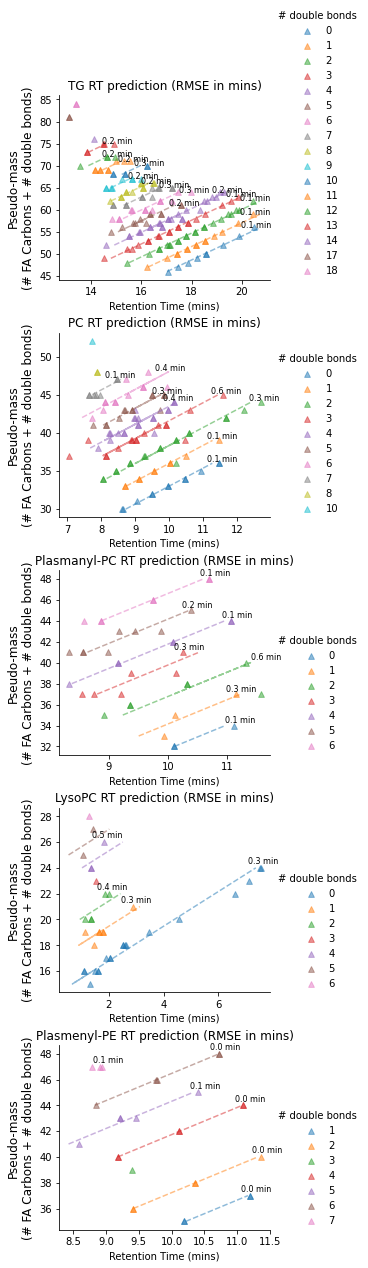

In [17]:
lipid_classes = data['Lipid Class'].value_counts().index[0:5]
fig, axs = plt.subplots(nrows=len(lipid_classes), figsize=(5, 3.5*len(lipid_classes)), constrained_layout=True)

for i, cls in enumerate(lipid_classes):
    df = data.loc[data['Lipid Class'] == cls]
    try:
        with warnings.catch_warnings(record=True) as model_warning:
            me = smf.mixedlm(f'RT ~ C', data=df, groups='unsat_cat').fit(reml=True)
            if model_warning:
                print(f'Warning for {cls}')
    except:
        print(cls, 'skipped')
        continue
    main_intercept = me.params['Intercept']
    C_coef = me.params['C']
    ax = axs[i]
    for unsat in sorted(df['unsat'].unique()):
        Cs = df.loc[df['unsat'] == unsat, 'C'].values
        intercept = main_intercept + me.random_effects[unsat].iloc[0]
        # RT will be on x-axis by convention, even though it's being predicted
        rt_pred = (Cs * C_coef) + intercept
        rt_true = df.loc[(df['unsat'] == unsat) & (df['C'].isin(Cs)), 'RT']
        mzs = Cs + unsat
        ax.plot(rt_pred, mzs, '--', alpha=0.5)
        ax.scatter(rt_true, mzs, marker='^', s=33, alpha=0.5, label=int(unsat))
        if len(rt_pred) > 2:
            rmse = np.sqrt(mean_squared_error(y_true=rt_true, y_pred=rt_pred))
            ax.text(s=f'{round(rmse, 1)} min', x=max(rt_true)+0.1, y=max(mzs)+0.5, 
                    fontsize=8, ha='center', va='center')
    ax.set_xlabel('Retention Time (mins)')
    ax.set_ylabel('Pseudo-mass\n(# FA Carbons + # double bonds)', fontsize=12)
    ax.set_title(f'{cls} RT prediction (RMSE in mins)', )
    ax.legend(loc=(1.02, 0.0), title='# double bonds', frameon=False)
sns.despine()

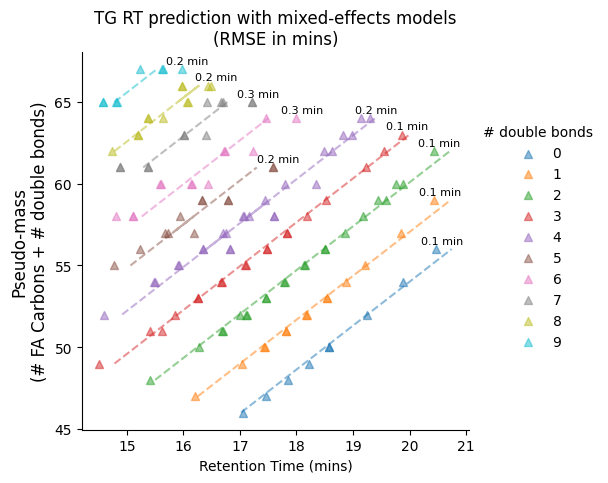

In [8]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)
me = smf.mixedlm(f'RT ~ C', data=data.loc[data['Lipid Class'] == 'TG'], groups='unsat_cat').fit(reml=True)
main_intercept = me.params['Intercept']
C_coef = me.params['C']

for unsat in sorted(tg['unsat'].unique())[:10]:
    Cs = tg.loc[tg['unsat'] == unsat, 'C'].values
    intercept = main_intercept + me.random_effects[unsat].iloc[0]
    # RT will be on x-axis by convention, even though it's being predicted
    rt_pred = (Cs * C_coef) + intercept
    rt_true = tg.loc[(tg['unsat'] == unsat) & (tg['C'].isin(Cs)), 'RT']
    mzs = Cs + unsat
    ax.plot(rt_pred, mzs, '--', alpha=0.5)
    ax.scatter(rt_true, mzs, marker='^', s=33, alpha=0.5, label=int(unsat))
    rmse = np.sqrt(mean_squared_error(y_true=rt_true, y_pred=rt_pred))
    ax.text(s=f'{round(rmse, 1)} min', x=max(rt_true)+0.1, y=max(mzs)+0.5, fontsize=8, ha='center', va='center')
ax.set_xlabel('Retention Time (mins)')
ax.set_ylabel('Pseudo-mass\n(# FA Carbons + # double bonds)', fontsize=12)
ax.set_title('TG RT prediction with mixed-effects models\n(RMSE in mins)', )
ax.legend(loc=(1.02, 0.2), title='# double bonds', frameon=False)
sns.despine()

In [ ]:
with warnings.catch_warnings(record=True) as warning_gluc_tol:
            no_gluc_tol = smf.mixedlm(f'{f} ~            bg_type', df, groups=df['animal']).fit(maxiter=50, reml=False)